# Variational quantum simulation

The matrix equation becomes

$$
\begin{pmatrix}
    1 & 0\\
    0 & \frac{\alpha^{2}}{4}
\end{pmatrix}
\begin{pmatrix}
    \dot{\alpha}\\
    \dot{\theta}
\end{pmatrix}
= 
\begin{pmatrix}
    \frac{\alpha}{2}  <\tilde{\Psi}(\theta)| \sigma_{y} |\tilde{\Psi}(\theta)>\\
    \frac{\alpha^{2}}{2}(1-\frac{1}{2}<\tilde{\Psi}(\theta)| \sigma_{z} |\tilde{\Psi}(\theta)>)
\end{pmatrix}
$$

$$
\begin{pmatrix}
    \dot{\alpha}\\
    \dot{\theta}
\end{pmatrix}
= 
\text{Inverse}(\begin{pmatrix}
    1 & 0\\
    0 & \frac{\alpha^{2}}{4}
\end{pmatrix})
\begin{pmatrix}
    \frac{\alpha}{2} <\tilde{\Psi}(\theta)| \sigma_{y} |\tilde{\Psi}(\theta)>\\
    \frac{\alpha^{2}}{2}(1-\frac{1}{2}<\tilde{\Psi}(\theta)| \sigma_{z} |\tilde{\Psi}(\theta)>)
\end{pmatrix}
$$

### Variables at a later time

Euler algorithm to determine the variables at a later time
$$
\begin{pmatrix}
    \alpha(t+dt)\\
    \theta(t+dt)
\end{pmatrix}
= \begin{pmatrix}
    \alpha(t)\\
    \theta(t)
\end{pmatrix}+
dt
\begin{pmatrix}
    \dot{\alpha}\\
    \dot{\theta}
\end{pmatrix}
$$

### Expectation values of Pauli operators

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.opflow import X, Y, Z, I
from qiskit.opflow import CircuitStateFn
from qiskit.opflow.state_fns import StateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.opflow.converters import CircuitSampler
from qiskit.providers.aer import QasmSimulator

# U_1(theta) = exp(-i * theta/2 * sigma_x)
sigma_X = np.matrix([[0, 1], [1, 0]])
def U_1(theta):
     return expm(-1j*theta*0.5*sigma_X)
    
def Expectation_Values(theta_1):
    
    psi = QuantumCircuit(1) # Initially |psi> = |0>.
    
    psi.unitary(U_1(theta_1),0) # |psi_tilde> = exp(-i * theta/2 * sigma_x) |0>.
    
    psi = CircuitStateFn(psi)
    
    # Choosing the operator whose expectation to be measured.
    op_0 = Y
    # Performing <psi | op |psi>.
    measurable_expression = StateFn(op_0, is_measurement = True).compose(psi)

    # Expectation value in the sigma_z basis aka computational basis.
    expectation = PauliExpectation().convert(measurable_expression)

    # Simulating.
    simulator = QasmSimulator()
    sampler = CircuitSampler(simulator).convert(expectation)
    V_0 = sampler.eval().real # Returning the <psi | sigma_y |psi>.
    
    
    
    psi = QuantumCircuit(1) # Initially |psi> = |0>.
    
    psi.unitary(U_1(theta_1),0) # |psi_tilde> = exp(-i * theta/2 * sigma_x) |0>.
    
    psi = CircuitStateFn(psi)
    
    # Choosing the operator whose expectation to be measured.
    op_1 = Z
    # Performing <psi | op |psi>.
    measurable_expression = StateFn(op_1, is_measurement = True).compose(psi)

    # Expectation value in the sigma_z basis aka computational basis.
    expectation = PauliExpectation().convert(measurable_expression)

    # Simulating.
    simulator = QasmSimulator()
    sampler = CircuitSampler(simulator).convert(expectation)
    V_1 = sampler.eval().real # Returning the <psi | sigma_z |psi>.  
    
    return V_0, V_1 # <psi|sigma_y|psi>, <psi|sigma_z|psi>.

In [2]:
Expectation_Values(0.0)

(-0.044921874999999944, 1.0)

In [3]:
Expectation_Values(np.pi)

(-0.01171875, -1.0)

In [9]:
t = 0.0
dt = 0.15
Time = [t]

alpha_0 = 1
theta_0 = np.pi

alpha = alpha_0
theta = theta_0

alpha_s = [alpha]
theta_s = [theta]

# Run the expectation value.
M = Expectation_Values(theta_0)
while t < 5:
    
    alpha_dot = (alpha/2) * M[0]
    theta_dot = 2-M[1]
    
    alpha = alpha + (dt * alpha_dot)
    theta = theta + (dt * theta_dot)
    
    alpha_s.append(alpha)
    theta_s.append(theta)
    t = t + dt
    Time.append(t)
    
    # Running with updated values of theta.
    M = Expectation_Values(theta) 

In [10]:
ket_zero = np.matrix([[1],[0]])
def L(alpha_list, theta_list):
    overlap_list = []
    psi_tilde_zero = expm(-1j*theta_0*0.5*sigma_X)*ket_zero
    for i in range(len(theta_list)):
        psi_tilde_t    = expm(-1j * theta_list[i] * 0.5*sigma_X)*ket_zero
        overlap_list.append((alpha_list[i]*abs(psi_tilde_t.getH()*psi_tilde_zero)).tolist()[0][0])
    return overlap_list

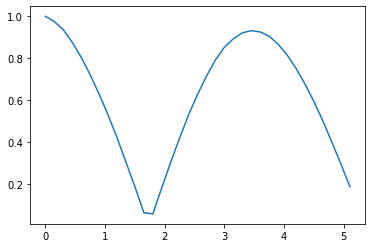

In [11]:
import matplotlib.pyplot as plt
plt.plot(Time,L(alpha_s,theta_s))
plt.show()

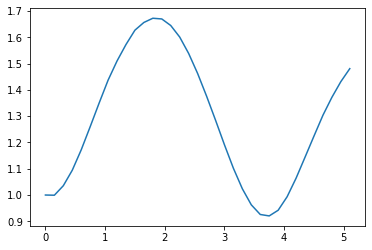

In [12]:
plt.plot(Time,alpha_s)
plt.show()

### Previous code

In [8]:
sigma_X = np.matrix([[0, 1], [1, 0]])
sigma_Y = np.matrix([[0,-1j],[1j,0]])
sigma_Z = np.matrix([[0,1],[1,0]])
def Psi_ansatz(alpha,theta,state_initial):
    return alpha * np.exp(-(1j/2)*theta*sigma_X)*state_initial

def Psi_tilde(theta,state_initial):
    return np.exp(-(1j/2)*theta*Pauli_X)*state_initial

### Loads the IBM Quantum

### Circuit for $M_{ij}$

### Circuit for $V_{j}$